Import library

In [1]:
import os
import json
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
directory = 'music'

jsonPath = 'data.json'

# sample rate
sr = 22050

totalSample = 29 * sr

# slice the dataset into smaller pieces
numSlices = 10
samplePerSlice = int(totalSample/numSlices)

為了對音頻樣本進行分類，將通過計算它們的 MFCC 來對它們進行預處理，這是每個感知頻帶的能量的時間表示。

在這種情況下，選擇了 13 個波段。

除此之外，也計算出它們的 RMS(root-mean-square), ZCR(zero-crossing rate), spectral centroid, roll-off，作為特徵嘗試用來輔助訓練。

In [3]:
def preprocessData(directory, jsonPath):
    processedData =  {"labels": [], "mfcc": [], "rms":[], "zcr":[], "spectralCentroid": [], "rollOff":[]}

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(directory)):
        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
            for s in range(numSlices):
                startTime = samplePerSlice * s
                endTime = startTime + samplePerSlice
                mfcc = librosa.feature.mfcc(y=song[startTime:endTime], sr=sr, n_mfcc=13)
                # root-mean-square
                rms = librosa.feature.rms(y=song[startTime:endTime])
                # zero-crossing rate
                zcr = librosa.feature.zero_crossing_rate(y=song[startTime:endTime])
                # spectral centroid
                spectralCentroid = librosa.feature.spectral_centroid(y=song[startTime:endTime], sr=sr)
                # roll-off
                rollOff = librosa.feature.spectral_rolloff(y=song[startTime:endTime], sr=sr)

                mfcc = mfcc.T
                rms = rms.T
                zcr = zcr.T
                spectralCentroid = spectralCentroid.T
                rollOff = rollOff.T
                melSpectrogram = melSpectrogram.T

                processedData['labels'].append(i-1)
                processedData['mfcc'].append(mfcc.tolist())
                processedData['rms'].append(rms.tolist())
                processedData['zcr'].append(zcr.tolist())
                processedData['spectralCentroid'].append(spectralCentroid.tolist())
                processedData['rollOff'].append(rollOff.tolist())

    with open(jsonPath, 'w') as f:
        json.dump(processedData, f)
    f.close()

經過多次嘗試，以 MFCC 個別搭配 RMS, ZCR, spectral centroid, roll-off，訓練的準確率極差(皆約 10%±2%)，故最終模型訓練使用的特徵以 MFCC 的 13 個波段呈現。

In [4]:
def loadData(jsonPath):
    with open(jsonPath, 'r') as f:
        data = json.load(f)
    f.close()
    
    mfcc = np.array(data['mfcc'])
    rms = np.array(data['rms'])
    zcr = np.array(data['zcr'])
    spectralCentroid = np.array(data['spectralCentroid'])
    rollOff = np.array(data['rollOff'])
    
#     features = [];
#     for i in range(len(data['labels'])):
#         features.append(np.hstack( (mfcc[0], rms[0]) ) )
#         features.append(np.hstack( (mfcc[0], zcr[0],) ) )
#         features.append(np.hstack( (mfcc[0], spectralCentroid[0]) ) )
#         features.append(np.hstack( (mfcc[0], rollOff[0]) ) )
    
#     X = np.array(features)
    Y = np.array(data['labels'])

    return mfcc, Y

切割訓練資料與測試資料，train_size : test_size = 8 : 2

其中，訓練資料又將被切分出訓練集與測試集 train : validation = 8 : 2

In [5]:
def makeTrainingData(X, Y, splitSize):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=splitSize)
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=splitSize)
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

建構模型

In [6]:
def modelBuilding(inputShape):
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=inputShape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(Y)), activation='softmax')
    ])

    return model

In [7]:
def plotPerformance(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'red', label='Training accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'red', label='Training Loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
def modelPredict(model, X, y):
    
    predictions = model.predict(Xtest)
    result = []
    for i in predictions:
        result.append(np.argmax(i));
    result = np.array(result)
    
    correct = 0;
    for i in range(len(YTest)):
        correct += 1 if(result[i] == YTest[i]) else 0
    print('accuracy: {0} ({1} / {2})'.format(correct/len(YTest), correct, len(YTest)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 64)         36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 2, 64)        0         
 2D)                                                             
                                                        

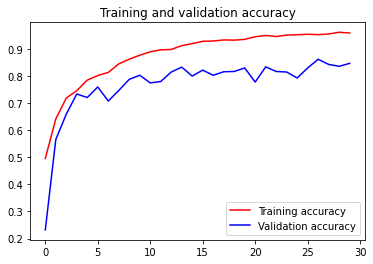

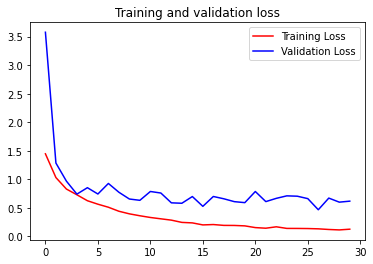

accuracy: 0.82625 (661 / 800)


In [9]:
if __name__ == "__main__":
    preprocessData(directory, csvPath)
    
    X, Y = loadData(jsonPath)
    
    Xtrain, Xval, Xtest, Ytrain, Yval, YTest = makeTrainingData(X, Y, 0.2)
    
    inputShape = (Xtrain.shape[1], Xtrain.shape[2],1)
    
    model = modelBuilding(inputShape)
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )
    model.summary()
    
    history = model.fit(Xtrain, Ytrain,
                        validation_data=(Xval, Yval),
                        epochs=30,
                        batch_size=32
                        )
    plotPerformance(history)
    
    # 使用模型預測未經過訓練的測試資料
    modelPredict(model, Xtest, YTest)